frequency format/natural frequencies - use counts rather than probabilities

In [1]:
import os

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import gaussian_kde

import jax.numpy as jnp
from jax import random, vmap

import numpyro
import numpyro.distributions as dist

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
az.style.use("arviz-darkgrid")

In [2]:
p_grid = jnp.linspace(0, 1, 1000)
prob_p = jnp.repeat(1, 1000)

prob_data = jnp.exp(dist.Binomial(
    total_count=9,
    probs=p_grid
).log_prob(6))

posterior = prob_data * prob_p
posterior = posterior / jnp.sum(posterior)

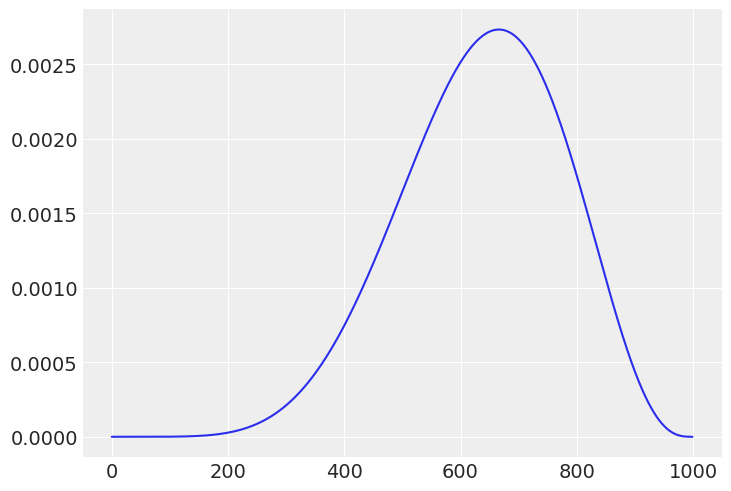

In [3]:
plt.plot(posterior)

In [4]:
samples = p_grid[dist.Categorical(probs=posterior).sample(random.PRNGKey(0), (10000,))]

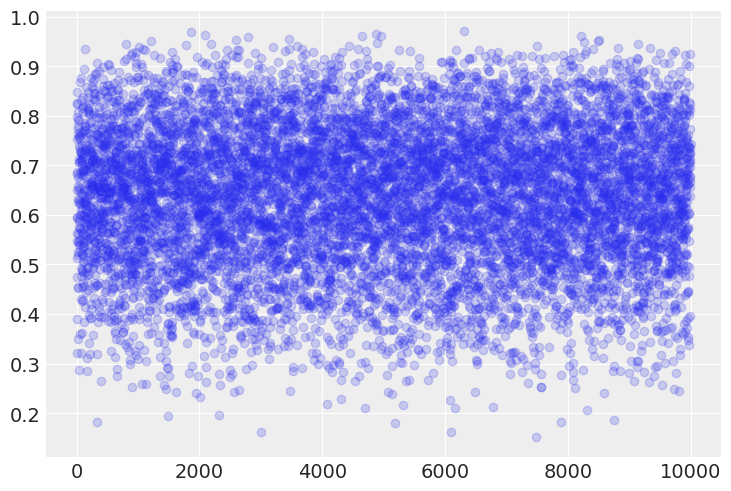

In [5]:
plt.scatter(range(len(samples)),samples, alpha=0.2)

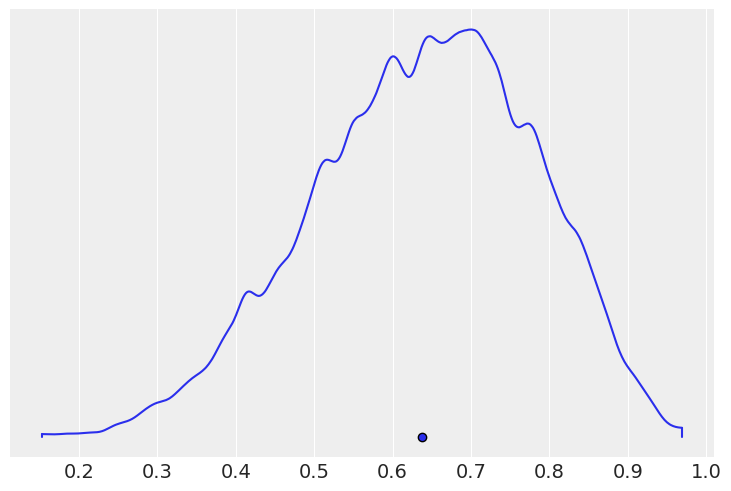

In [6]:
az.plot_density({"":samples},hdi_prob=1)
plt.show()

1. how much opsteriror prob below param
1. how mjch posterior between two param
1. which param makes 5% less posterior
1. which range contains 90% of posterior prob
1. which param has highest posteriro prob

In [7]:
sum(posterior[p_grid < 0.5])

0.1718745963345375

In [8]:
sum(samples < 0.5) / 1e4

0.1711

In [9]:
sum((samples > 0.5) & (samples < 0.75)) / 1e4

0.6025

~Credible interval~ compatbility interval. 

It is interval that best compatible and describes th model and data

In [10]:
jnp.quantile(samples, 0.8)

DeviceArray(0.7637638, dtype=float32)

In [11]:
jnp.quantile(samples, jnp.array([.1, .9]))

DeviceArray([0.44644645, 0.8168168 ], dtype=float32)

Percentile Intervals - equal probability mass.



In [12]:
p_grid = jnp.linspace(start=0, stop=1, num=1000)
prior = jnp.repeat(1, 1000)
likelihood = jnp.exp(dist.Binomial(
    total_count=3,
    probs=p_grid
).log_prob(3))
posterior = likelihood * prior
posterior = posterior / jnp.sum(posterior)

In [13]:
samples = p_grid[dist.Categorical(probs=posterior).sample(random.PRNGKey(0), 
(10000,))]

In [14]:
jnp.percentile(samples, q=(25, 75))

DeviceArray([0.7077077, 0.9319319], dtype=float32)

In [15]:
numpyro.diagnostics.hpdi(samples, prob=0.5)

array([0.8418418, 0.998999 ], dtype=float32)

Highest posterior density Interval - narrowest interval conatined the specified probabilty mass

HDPI - high density posterior interval
PI - percentile interval
They are only different for highly skewed distribution. 


HDPI disadvantage - it's must computational intensive than PI. greater simulation variance.

If the choise of interval type makes a difference, you shouldn't be using them to summarize the posterior. 



Meaning of compatibility intervals

- 95% confidence interval means there is a probabily of 95% that true paramter lies between the interval.

strict non-bayesain forbid using probabilty to measure un to measure uncertainty of paramters

we could say " if we repeat the study x number of times, 95% of the computed interval would contain the true paramter value.

bayesian interpretation: 
- 

In [16]:
p_grid[jnp.argmax(posterior)]

DeviceArray(1., dtype=float32)

In [17]:
samples[jnp.argmax(gaussian_kde(samples, bw_method=0.01)(samples))]

DeviceArray(0.988989, dtype=float32)

In [18]:
jnp.mean(samples)

DeviceArray(0.8011086, dtype=float32)

In [19]:
jnp.median(samples)

DeviceArray(0.8428428, dtype=float32)

In [20]:
jnp.sum(posterior *jnp.absolute(0.5 - p_grid))

DeviceArray(0.31287515, dtype=float32)

In [21]:
loss = vmap(lambda d: jnp.sum(posterior * jnp.abs(d-p_grid)))(p_grid)

In [22]:
p_grid[jnp.argmin(loss)]

DeviceArray(0.8408408, dtype=float32)

In [23]:
jnp.median(samples
)

DeviceArray(0.8428428, dtype=float32)

absolute loss leads you to median

quadratic loss leads you to mean

Model design - sample from prior
- see what the model expects before it arrives

model checking - worth simulating implifed observation

software validation - it helps ot simulate observation under known model. 

research design - if you can simulate observation from hypothesis, then you can evaluate whether reserah can be effective

forecasting - estimate can be used to make new predictions

Bayesian are always generative

$$
Let W = water \\

Let N = number of tosses \\

Pr(W|N, p) = \frac{N!}{W!(N-W)!}p^W(1-p)^{N-W}

In [24]:
# throw it 2 times, p = 0.7
jnp.exp(dist.Binomial(total_count=2,probs=0.7).log_prob(jnp.arange(3)))

DeviceArray([0.09000004, 0.42000008, 0.49000022], dtype=float32)

9% of w = 0, 42% for w =1, and 49% w = 2

In [25]:
dist.Binomial(total_count=2, probs=0.7).sample(random.PRNGKey(0))

DeviceArray(1, dtype=int32)

In [26]:
dist.Binomial(total_count=2, probs=0.7).sample(random.PRNGKey(2), (10,))

DeviceArray([2, 1, 2, 1, 1, 2, 2, 2, 2, 1], dtype=int32)

In [27]:
dummy_w = dist.Binomial(total_count=2, probs=0.7).sample(random.PRNGKey(2), (100000,))

In [28]:
jnp.unique(dummy_w, return_counts=True)[1] /1e5

DeviceArray([0.09124, 0.42092, 0.48784], dtype=float32)

In [29]:
jnp.unique(dummy_w, return_counts=True)[1] / 1e5

DeviceArray([0.09124, 0.42092, 0.48784], dtype=float32)

In [30]:
dummy_w = dist.Binomial(total_count=9, probs=0.7).sample(
    random.PRNGKey(2), (100000,)
)

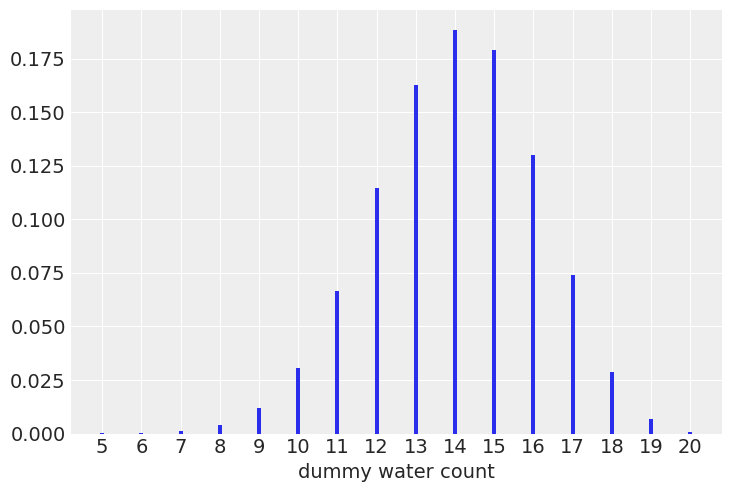

In [31]:
dummy_w = dist.Binomial(total_count=20, probs=0.7).sample(random.PRNGKey(0), (100000,))
ax = az.plot_dist(dummy_w.copy(), kind="hist", hist_kwargs={"rwidth": 0.1})
ax.set_xlabel("dummy water count", fontsize=14)
plt.show()

In [32]:
dist.Binomial(total_count=2, probs=.7).sample(
    random.PRNGKey(0), (10,)
)

Buffer([1, 1, 1, 2, 2, 1, 1, 2, 0, 1], dtype=int32)

In [33]:
dummy_w = dist.Binomial(total_count=2, probs=.7).sample(
    random.PRNGKey(0), (100000,)
)

In [34]:
jnp.unique(dummy_w, return_counts=True)[1] / 1e5

DeviceArray([0.0888 , 0.41789, 0.49331], dtype=float32)

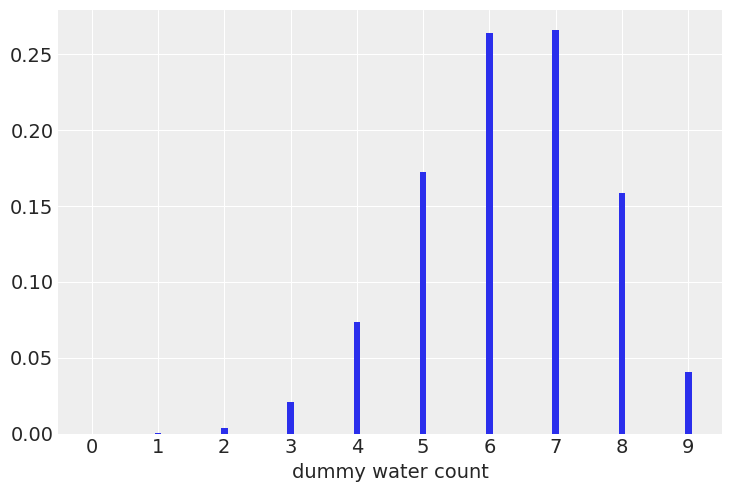

In [35]:
dummy_w = dist.Binomial(total_count=9, probs=0.7).sample(random.PRNGKey(0), (100000,))
ax = az.plot_dist(dummy_w.copy(), kind="hist", hist_kwargs={"rwidth": 0.1})
ax.set_xlabel("dummy water count", fontsize=14)
plt.show()

In [36]:
w = dist.Binomial(total_count=9, probs=samples).sample(random.PRNGKey(0))


Practice

In [37]:
p_grid = jnp.linspace(start=0, stop=1, num=1000)
prior = jnp.repeat(1, 1000)
likelihood = jnp.exp(dist.Binomial(
    total_count=9,
    probs=p_grid
).log_prob(6))
posterior = likelihood * prior
posterior = posterior / jnp.sum(posterior)
#random.seed(100)
samples = p_grid[dist.Categorical(probs=posterior).sample(random.PRNGKey(0), (10000,))]

In [38]:
p_grid = jnp.linspace(start=0, stop=1, num=1000)
prior = jnp.repeat(1, 1000)
likelihood = jnp.exp(dist.Binomial(total_count=9, probs=p_grid).log_prob(6))
posterior = likelihood * prior
posterior = posterior / jnp.sum(posterior)
samples = p_grid[dist.Categorical(posterior).sample(random.PRNGKey(100), (10000,))]

In [39]:
jnp.sum(posterior[posterior<0.2]) / 1e4

DeviceArray(1.e-04, dtype=float32)

In [40]:
#3E1
jnp.sum(samples[samples < 0.2]) / 1e4

DeviceArray(0.00017918, dtype=float32)

In [41]:
#3E2
jnp.sum(samples[samples > 0.8]) / 1e4

DeviceArray(0.10273184, dtype=float32)

In [42]:
jnp.sum(samples[(samples < 0.8) & ( samples > 0.2)]) / 1e4

DeviceArray(0.5344119, dtype=float32)

In [43]:
# 3e4
jnp.quantile(samples, 0.2)

DeviceArray(0.5185185, dtype=float32)

In [44]:
# 3E5
jnp.quantile(samples, 0.8)

DeviceArray(0.7607608, dtype=float32)

In [45]:
# 3e6
numpyro.diagnostics.hpdi(samples, prob=0.66)

array([0.5155155, 0.7847848], dtype=float32)

In [46]:
# 3e7
jnp.percentile(samples, q=(17,83))

DeviceArray([0.5023324, 0.7737738], dtype=float32)

In [47]:
samples

DeviceArray([0.7247247, 0.6156156, 0.7437437, ..., 0.6116116, 0.6676677,
             0.5385385], dtype=float32)

# 3M1

In [48]:
p_grid = jnp.linspace(start=0, stop=1, num=1000)
prior = jnp.repeat(1, 1000)
likelihood = jnp.exp(dist.Binomial(total_count=15, probs=p_grid).log_prob(8))
posterior = likelihood * prior
posterior = posterior / jnp.sum(posterior)
samples = p_grid[dist.Categorical(posterior).sample(random.PRNGKey(100), (10000,))]

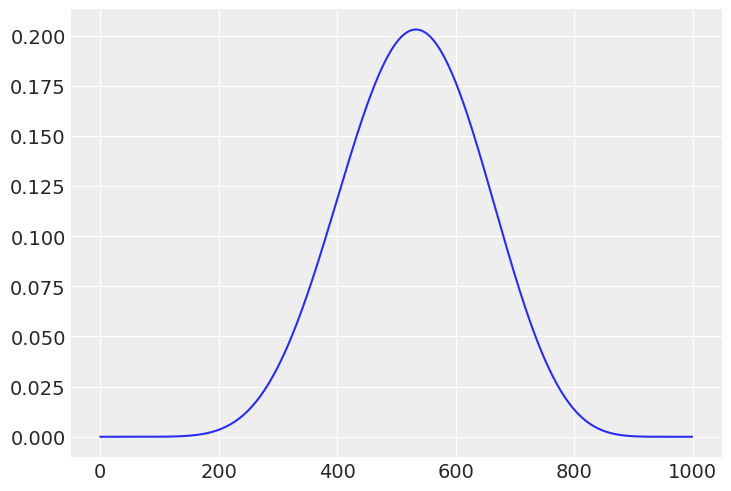

In [49]:
plt.plot(likelihood)

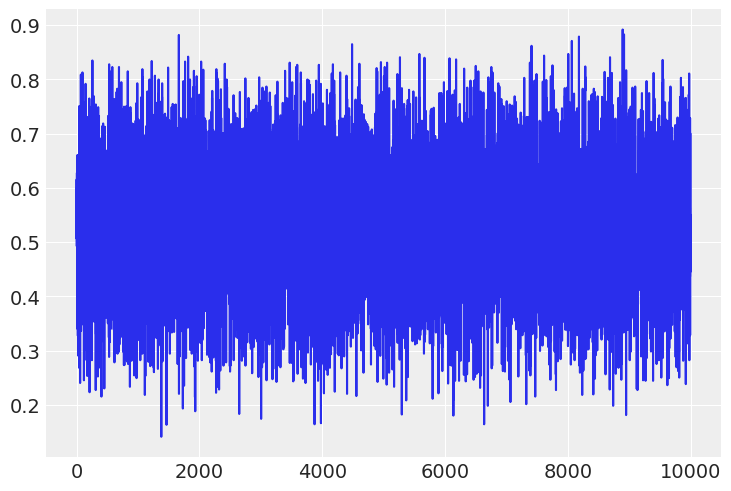

In [50]:
plt.plot(samples)

In [51]:
numpyro.diagnostics.hpdi(samples, prob=0.8)

array([0.3823824, 0.6846847], dtype=float32)

# 3M3

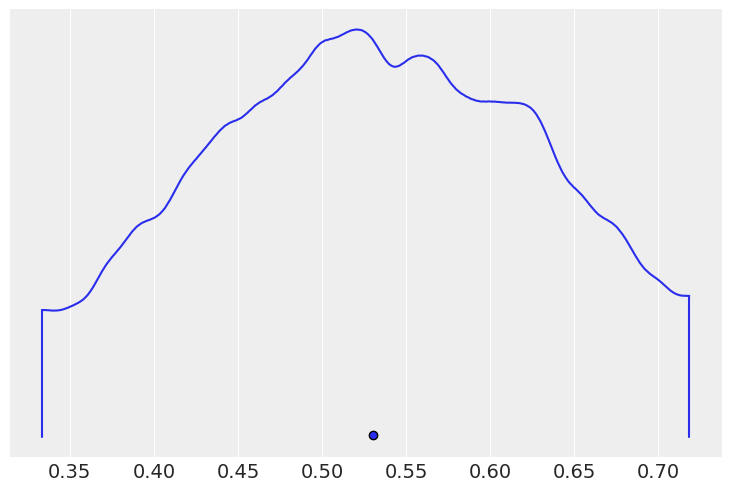

In [52]:
az.plot_density({"":samples},hdi_prob=0.9)
plt.show()

In [53]:
s = dist.Binomial(total_count=15, probs=0.53).sample(random.PRNGKey(2), (1000,))
jnp.unique(s, return_counts=True)

(DeviceArray([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13], dtype=int32),
 DeviceArray([  4,  11,  23,  77, 110, 196, 198, 177, 110,  66,  21,   7], dtype=int32))

In [54]:
196/1000

0.196

In [55]:
8/15

0.5333333333333333

# 3M4

In [56]:
s = dist.Binomial(total_count=15, probs=posterior).sample(random.PRNGKey(2), (1000,))
jnp.unique(s, return_counts=True)

(DeviceArray([0, 1, 2, 3], dtype=int32),
 DeviceArray([985251,  14508,    235,      6], dtype=int32))

In [57]:
8/15

0.5333333333333333

In [58]:
dummy_w = dist.Binomial(total_count=15, probs=0.5333).sample(random.PRNGKey(0), (100000,))
jnp.unique(dummy_w, return_counts=True)
#jnp.unique(dummy_w, return_counts=True)[1] / 1e5

(DeviceArray([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,
              15], dtype=int32),
 DeviceArray([    2,    22,   134,   715,  2580,  6398, 12140, 17633,
              20115, 17912, 12509,  6612,  2449,   683,    89,     7],            dtype=int32))

In [59]:
jnp.unique(dummy_w, return_counts=True)[1][8] /1e5

DeviceArray(0.20115, dtype=float32)

In [60]:
dummy_w = dist.Binomial(total_count=15, probs=posterior).sample(random.PRNGKey(0), (1000,))
jnp.unique(dummy_w, return_counts=True)

(DeviceArray([0, 1, 2, 3], dtype=int32),
 DeviceArray([985396,  14367,    236,      1], dtype=int32))

# 3M5 

In [61]:
p_grid = jnp.linspace(start=0, stop=1, num=1000)

In [62]:
prior = jnp.array([0 if x < 0.5 else 1 for x in p_grid])
likelihood = jnp.exp(dist.Binomial(total_count=15, probs=p_grid).log_prob(8))
posterior = likelihood * prior
posterior = posterior / jnp.sum(posterior)
samples = p_grid[dist.Categorical(posterior).sample(random.PRNGKey(100), (10000,))]

In [63]:
"""
p_grid <- seq( from=0 , to=1 , length.out=1000 )
prior <- ifelse( p_grid < 0.5 , 0 , 1 )
likelihood <- dbinom( 8 , size=15 , prob=p_grid )
posterior <- likelihood * prior
posterior <- posterior / sum(posterior)
samples <- sample( p_grid , prob=posterior , size=1e4 , replace=TRUE )
plot( posterior ~ p_grid , type="l" )
"""

'\np_grid <- seq( from=0 , to=1 , length.out=1000 )\nprior <- ifelse( p_grid < 0.5 , 0 , 1 )\nlikelihood <- dbinom( 8 , size=15 , prob=p_grid )\nposterior <- likelihood * prior\nposterior <- posterior / sum(posterior)\nsamples <- sample( p_grid , prob=posterior , size=1e4 , replace=TRUE )\nplot( posterior ~ p_grid , type="l" )\n'

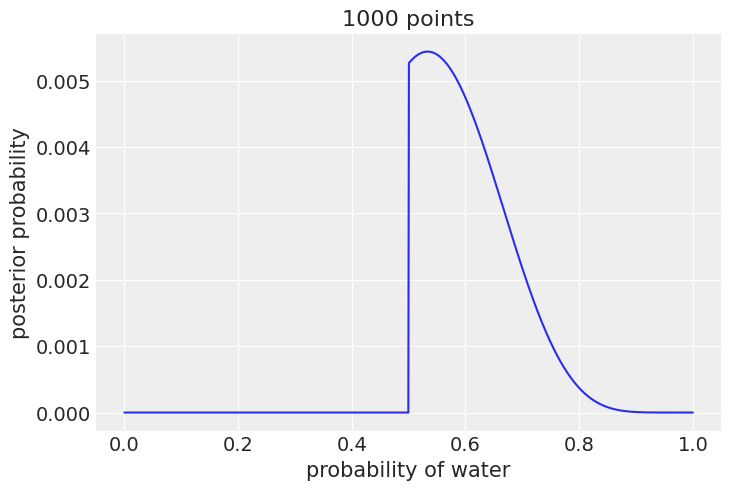

In [64]:
plt.plot(p_grid, posterior)
plt.xlabel("probability of water")
plt.ylabel("posterior probability")
plt.title("1000 points")
plt.show()

In [65]:
numpyro.diagnostics.hpdi(samples, prob=0.9)

array([0.5005005, 0.7117117], dtype=float32)

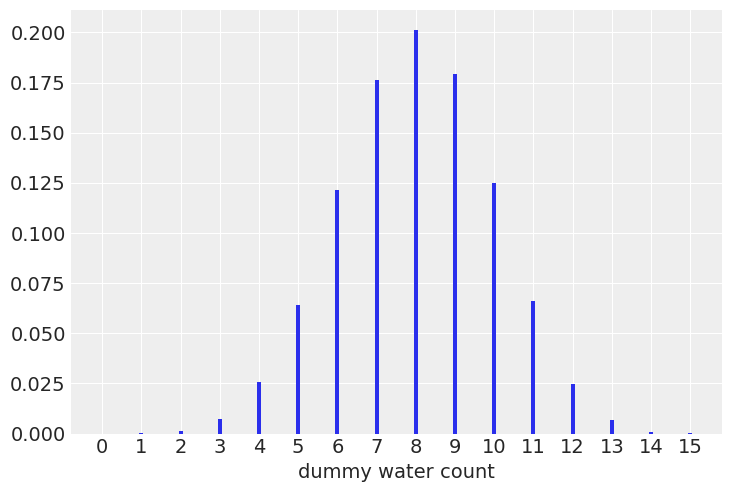

In [66]:
dummy_w = dist.Binomial(total_count=15, probs=8/15).sample(random.PRNGKey(0), (100000,))
ax = az.plot_dist(dummy_w.copy(), kind="hist", hist_kwargs={"rwidth": 0.1})
ax.set_xlabel("dummy water count", fontsize=14)
plt.show()

Hard

In [68]:
# fmt: off
birth1 = jnp.array([
    1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
    0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0,
    1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1,
    0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
])
birth2 = jnp.array([
    0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
    0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
    0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
])

In [79]:
boys = int(jnp.sum(birth1) + jnp.sum(birth2))

In [80]:
boys

111

In [76]:
p = jnp.linspace(start=0, stop=1, num=1000)
prior = jnp.repeat(1, 1000)

In [82]:
likelihood = jnp.exp(dist.Binomial(
    total_count=200,
    probs = p_grid
).log_prob(boys))

In [86]:
posterior = prior * likelihood
posterior = posterior / jnp.sum(posterior)

Text(0, 0.5, 'posterior')

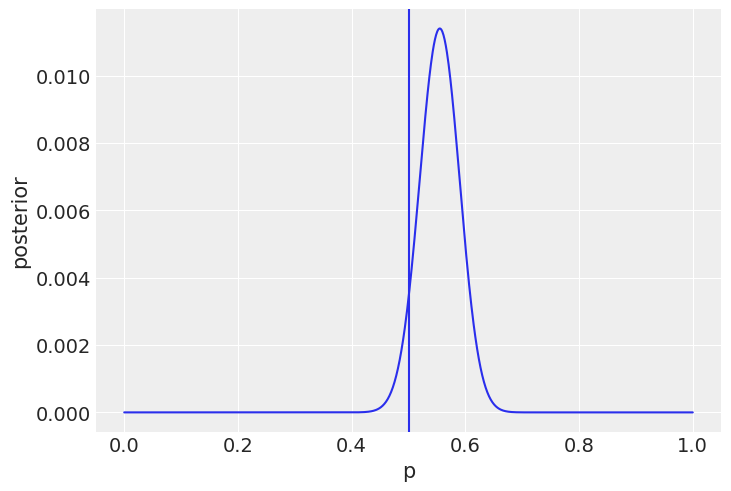

In [95]:
plt.plot(p, posterior)
plt.axvline(0.5)
plt.xlabel('p')
plt.ylabel('posterior')

In [93]:
p_grid[jnp.argmax(posterior)]

DeviceArray(0.5545546, dtype=float32)

# 3H2

In [96]:
samples = p_grid[dist.Categorical(probs=posterior).sample(random.PRNGKey(0), (10000,))]

In [100]:
jnp.percentile(samples, q=(25, 75))

DeviceArray([0.5305305, 0.5785786], dtype=float32)

In [101]:
jnp.percentile(samples, q=(50 + 89//2, 50 - 89 // 2))

DeviceArray([0.6096096, 0.4994995], dtype=float32)

In [102]:
jnp.percentile(samples, q=(50 + 97//2, 50 - 97 // 2))

DeviceArray([0.6266266, 0.4824825], dtype=float32)

# 3H3

In [115]:
samples = p[dist.Categorical(probs=posterior).sample(random.PRNGKey(0), (10000,))]

In [117]:
w = dist.Binomial(total_count=1000, probs=samples).sample(random.PRNGKey(0), (200,))

In [121]:
len(w[0])

10000